In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [2]:
df = pd.read_csv('Stocks_Data_Sheet.csv', delimiter=None)

In [3]:
rendements = df.iloc[0:60, 1:]
r_matrix = rendements.to_numpy()

In [4]:
#Question 2a

def find_ptf(stocks_r, desired_r, rf):
    
    
    moyennes = np.mean(stocks_r, axis=0)
    excess_returns = stocks_r - moyennes
    cov_matrix = (excess_returns.T @ excess_returns ) / (stocks_r.shape[0] - 1)
    vecteur_unitaire = np.ones(len(moyennes))
    coeff_A = moyennes.T @ inv(cov_matrix) @ moyennes
    coeff_B = moyennes.T @ inv(cov_matrix) @ vecteur_unitaire
    coeff_C = vecteur_unitaire.T @ inv(cov_matrix) @ vecteur_unitaire
    mat_info = np.array([[coeff_A, coeff_B], [coeff_B, coeff_C]])
    vec_rp = np.array([[desired_r], [1]])
    r_uni = np.concatenate((np.array([moyennes]), np.array([vecteur_unitaire]))).T
    ptf_all = ((inv(cov_matrix) @ r_uni) @ inv(mat_info)) @ vec_rp
    risk_ptf = ((coeff_A - 2 * coeff_B * desired_r + coeff_C * desired_r**2) / (coeff_A * coeff_C - coeff_B **2)) ** 0.5
    r_z = (coeff_A - coeff_B * desired_r) / (coeff_B - coeff_C * desired_r)
    risk_z = ((coeff_A - 2 * coeff_B * r_z + coeff_C * r_z**2) / (coeff_A * coeff_C - coeff_B **2)) ** 0.5
    r_marché = (coeff_A - (coeff_B * rf)) / (coeff_B - (coeff_C * rf))
    
    return ptf_all, risk_ptf, desired_r, r_marché, cov_matrix, moyennes, mat_info

In [5]:
#La création de l'optimiseur
def optimize(stocks_r, desired_r, l_bound, u_bound, rf):
    values = find_ptf(stocks_r, desired_r, rf)
    cov_matrix = values[4]
    moyennes = values[5]
    def objective(w):
        return ((w @ cov_matrix ) @ w) ** 0.5
    #valeur initiale de w
    const = ({'type': 'eq', 'fun': lambda w: w @ moyennes - desired_r},
            {'type': 'eq', 'fun': lambda w: w @ np.ones(len(moyennes)) - 1},
            )
    b = []
    for i in range(len(moyennes)):
        b.append((l_bound, u_bound))
    b[0], b[1], b[4], b[5] = (l_bound, 0.2), (l_bound, 0.2), (l_bound, 0.2), (l_bound, 0.2)
    b = tuple(b)
    sol = minimize(objective, values[0], method='SLSQP', constraints = const, bounds=b)
    stdev = sol.fun
    obtained_r = sol.x @ moyennes
    return obtained_r, stdev, sol.x, sol.success

optimize(r_matrix, 0.06, -0.5, None, 0)

(0.05999999999981734,
 0.07503017561908713,
 array([-0.34597196,  0.08484638,  0.06781823,  0.21408857,  0.10608986,
        -0.01893676, -0.33320654, -0.1089058 , -0.20822061,  0.06523659,
         0.06512804,  0.01026747,  0.14793311,  0.1486579 ,  0.40305457,
         0.47565445,  0.06298592, -0.5       , -0.11179741,  0.77527801]),
 True)

(0.06000000000000009, 0.0749235266886946)

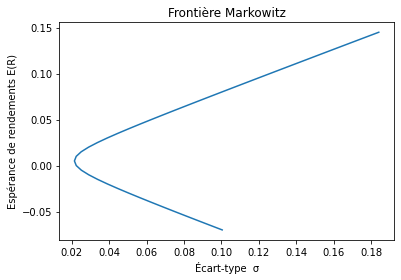

In [20]:
#Question 2a


def create_plot(stocks_r, l_bound, u_bound, rf):
    x_1_axis = []
    y_1_axis = []
    dt = optimize(stocks_r, -0.07, l_bound, u_bound, rf)
    s_max = (dt[0] - rf) / dt[1]
    for r in np.arange(-0.07, 0.15, 0.005):
        data = optimize(stocks_r, r, l_bound, u_bound, rf)
        if data[3] == True: 
            x_1_axis.append(data[1])
            y_1_axis.append(data[0])
            if (data[0] - rf) / data[1] > s_max:
                s_max = (data[0] - rf) / data[1]
                r_s_max = data[0]
                v_s_max = data[1] 
    plt.xlabel('Écart-type  \u03C3')
    plt.ylabel('Espérance de rendements E(R)')
    plt.title('Frontière Markowitz')
    plt.plot(x_1_axis, y_1_axis)
    return r_s_max, v_s_max

create_plot(r_matrix, None, None, 0)

(0.04000000000006362, 0.03948035718489339)

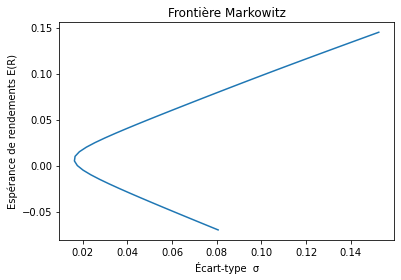

In [7]:
#Question 2b


create_plot(r_matrix[0:36], None, None, 0)

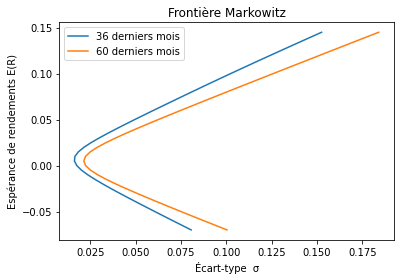

In [8]:
#Question 3

create_plot(r_matrix[0:36], None, None, 0)
create_plot(r_matrix, None, None, 0)
plt.legend(["36 derniers mois", "60 derniers mois"])
plt.show()

In [9]:
#Table of weight, variance, expected return from different timeframes
data_36 = find_ptf(r_matrix[0:36,], 0.05, 0.001)
all_60 = find_ptf(r_matrix, 0.05, 0.001)
#print(find_ptf(r_matrix[0:36,], 0.05, 0.001)[0])
#print(np.concatenate(find_ptf(r_matrix, 0.05, 0.001)[0], find_ptf(r_matrix[0:36,], 0.05, 0.001)[0].reshape(1, -1)))
var = np.var(r_matrix[0:36,], axis=0)
tab_36 = np.around(np.hstack((data_36[0], np.atleast_2d(var).T, np.atleast_2d(data_36[5]).T)), 3)
tab_60 = np.around(np.hstack((all_60[0], np.atleast_2d(np.var(r_matrix, axis=0)).T, np.atleast_2d(all_60[5]).T)), 3)
tab_36 = pd.DataFrame(tab_36, index=[df.columns[1:]], columns=["Weight", "Variance", "E[return]"])
tab_60 = pd.DataFrame(tab_60, index=[df.columns[1:]], columns=["Weight", "Variance", "E[return]"])

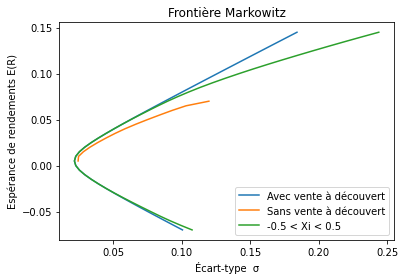

In [10]:
create_plot(r_matrix, None, None, 0)
create_plot(r_matrix, 0, None, 0)
create_plot(r_matrix, -0.5, 0.5, 0)
plt.legend(["Avec vente à découvert", "Sans vente à découvert", "-0.5 < Xi < 0.5"])
plt.show()

In [11]:
#Probs sur rf

def create_plot_rf(x_r_min, l_bound, u_bound, rf):
    r_mark = find_ptf(r_matrix, 0.05, rf)[3]
    var_ptf = find_ptf(r_matrix, r_mark, rf)[1] ** 2
    all_ptf = find_ptf(r_matrix, r_mark, rf)[0]
    x_axis = []
    y_axis = []
    for x in np.arange(x_r_min, 1.01, 0.1):
        x_axis.append((var_ptf * ((1 - x) ** 2)) ** 0.5)
        y_axis.append((r_mark * (1 - x) + (rf * x)))
    plt.xlabel('Écart-type  \u03C3')
    plt.ylabel('Espérance de rendements E(R)')
    plt.title('Frontière efficiente Markowitz')
    plt.plot(x_axis, y_axis)
    return 

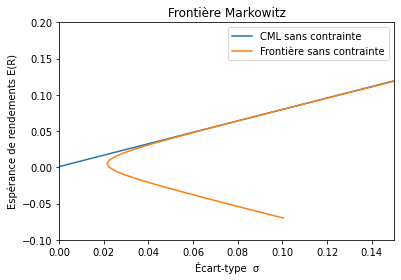

In [12]:
#Question 7


create_plot_rf(-2, None, None, 0.001)
create_plot(r_matrix, None, None, 0.001)
plt.legend(["CML sans contrainte", "Frontière sans contrainte"])
plt.xlim(left=0 ,right=0.15)
plt.ylim(ymax=0.2, ymin=-0.1)
plt.show()

In [13]:
def create_plot_rf2(x_r_min, l_bound, u_bound, rf):
    data = create_plot(r_matrix, l_bound, u_bound, rf)
    r_mark = data[0]
    var_ptf = data[1] ** 2
    x_axis = []
    y_axis = []
    for x in np.arange(x_r_min, 1.01, 0.1):
        x_axis.append((var_ptf * ((1 - x) ** 2)) ** 0.5)
        y_axis.append((r_mark * (1 - x) + (rf * x)))
    plt.xlabel('Écart-type  \u03C3')
    plt.ylabel('Espérance de rendements E(R)')
    plt.title('Frontière efficiente Markowitz')
    plt.xticks(np.arange(0, 0.2, 0.025))
    plt.yticks(np.arange(-0.1, 0.15, 0.025))
    plt.plot((var_ptf * 1)** 0.5, r_mark, 'r*')
    plt.plot(x_axis[5], y_axis[5], 'b*')
    plt.text(0.02, y_axis[5], f"Portefeuille choisi,         rendement = 7%, risque = 9%")
    plt.text(0.085, r_mark -0.001, "Portefeuille marché")
    plt.text(0.1, 0.1, "CML")
    plt.plot(x_axis, y_axis)
    return r_mark

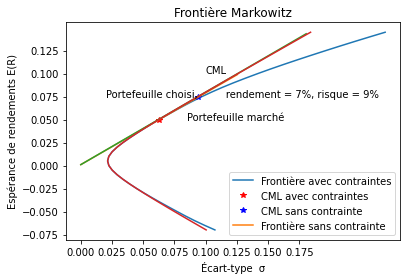

In [14]:
#Question 8


a = create_plot_rf2(-1, -0.5, 0.5, 0.001)
create_plot_rf(-1, None, None, 0.001)
create_plot(r_matrix, None, None, 0.001)
plt.legend(["Frontière avec contraintes", "CML avec contraintes", "CML sans contrainte", "Frontière sans contrainte"])
#plt.xlim(left=0 ,right=0.1)
#plt.ylim(ymax=0.1, ymin=-0.1)
plt.show()

In [15]:
our_ptf = optimize(r_matrix, a, -0.5, 0.5, 0.001)
our_ptf[2]

array([-0.26322362,  0.07605434,  0.05920162,  0.19743571,  0.12839753,
       -0.02786324, -0.27176813, -0.10056628, -0.17035889,  0.06900275,
        0.04123945,  0.00749228,  0.22309823,  0.12547508,  0.34557713,
        0.40102267,  0.13177098, -0.49540646,  0.02341885,  0.5       ])

In [16]:
#Création de tableaux

r = 0.06
w_wo = find_ptf(r_matrix, r, 0)[0].reshape(-1, 1)
w_w = optimize(r_matrix, r, -0.5, 0.5, 0.001)[2].reshape(-1, 1)
for i in np.arange(5):
    r += 0.005
    w_wo = np.append(w_wo, find_ptf(r_matrix, r, 0)[0].reshape(-1, 1), axis=1)
    w_w = np.append(w_w, optimize(r_matrix, r, -0.5, 0.5, 0.001)[2].reshape(-1, 1), axis=1)
tab_wo = pd.DataFrame(np.around(w_wo, 4), index=df.columns[1:], columns=[f"W for r={round(i, 3)}" for i in np.arange(0.06, 0.09, 0.005)])
tab_w = pd.DataFrame(np.around(w_w, 4), index=df.columns[1:], columns=[f"W for r={round(i, 3)}" for i in np.arange(0.06, 0.09, 0.005)])
#tableau de variance - rendement
var_wo = []
var_w = []
for r in np.arange(0.03, 0.11, 0.01):
    var_wo.append(find_ptf(r_matrix, r, 0)[1])
    var_w.append(optimize(r_matrix, r, -0.5, 0.5, 0)[1])
var_wo = np.array(var_wo).reshape(-1, 1)
var_w = np.array(var_w).reshape(-1, 1)
tab_rvar = np.hstack((var_wo, var_w))
tab_rvar = pd.DataFrame((np.around(tab_rvar, 4)), index=[f"r={round(i, 2)}" for i in np.arange(0.03, 0.11, 0.01)], columns=["\u03c3 sans contrainte", "\u03c3 avec contrainte"])
tab_rvar.T

,r=0.03,r=0.04,r=0.05,r=0.06,r=0.07,r=0.08,r=0.09,r=0.1
σ sans contrainte,0.039,0.0505,0.0625,0.0749,0.0875,0.1002,0.1130,0.1259
σ avec contrainte,0.039,0.0505,0.0628,0.0758,0.0896,0.1049,0.1224,0.1417


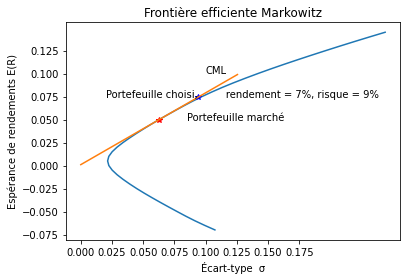

In [17]:
a = create_plot_rf2(-1, -0.5, 0.5, 0.001)